`ECML-PKDD 2024 Tutorial / An introduction to Time Series Machine Learning`

# Anomaly Detection with `aeon`

Time Series Anomaly Detection aims at discovering regions of a time series that in some
way are not representative of the underlying generative process. There is no universally
agreed upon definition for an anomaly, and different domains and algorithms have
different definitions for anomalies. In the context of this tutorial and within `aeon`,
we refer to any rare point or sequence of points that deviates from the normal behavior
of the time series as an anomaly.

The detectors have different capabilities that can be grouped into the following
categories, where `m` is the number of time points and `d` is the number of channels for
a time series:

Input data format (one of the following):

- **Univariate** series (default):

  - `np.ndarray`, shape `(m,)`, `(m, 1)` or `(1, m)` depending on axis.
  - `pd.DataFrame`, shape `(m, 1)` or `(1, m)` depending on axis.
  - `pd.Series`, shape `(m,)`.

- **Multivariate** series:

  - `np.ndarray` array, shape `(m, d)` or `(d, m)` depending on axis.
  - `pd.DataFrame`, shape `(m, d)` or `(d, m)` depending on axis.

Output data format (one of the following):

- Anomaly **scores** (default):
  `np.ndarray`, shape `(m,)` of type `float`. For each point of the input time series,
  the anomaly score is a float value indicating the degree of anomalousness. The higher
  the score, the more anomalous the point. The detectors return raw anomaly scores that
  are not normalized.

- **Binary** classification:
  `np.ndarray`, shape `(m,)` of type `bool` or `int`. For each point of the input time
  series, the output is a boolean or integer value indicating whether the point is
  anomalous (`True`/`1`) or not (`False`/`0`).

Detector learning types:

- **Unsupervised** (default):
  Unsupervised detectors do not require any training data and can directly be used on the
  target time series. You would usually call the fit_predict method on these detectors.

- **Semi-supervised**:
  Semi-supervised detectors require a training step on a time series without anomalies
  (normal behaving time series). The target value y would consist of only zeros. You
  would typically first call the fit method on the training time series and then the
  predict method on your target time series.

- **Supervised**:
  Supervised detectors require a training step on a time series with known anomalies
  (anomalies should be present and must be annotated). The detector implements the fit
  method, and the target value y consists of zeros and ones; ones indicating points of
  an anomaly. You would typically first call the fit method on the training data and then
  the predict method on your target time series.


In [ ]:
!pip install aeon==0.11.0 pyod stumpy
!mkdir -p data
!wget -nc https://raw.githubusercontent.com/aeon-tutorials/KDD-2024/main/Notebooks/data/KDD_MTSC_TRAIN.ts -P data/

In [1]:
# There are some deprecation warnings present in the notebook, we will ignore them.
# Remove this cell if you are interested in finding out what is changing soon, for
# aeon there will be big changes in out v1.0.0 release!
import warnings

warnings.filterwarnings("ignore")

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def mask_to_slices(mask):
    tmp = np.r_[0, mask, 0]
    slices = np.c_[
        np.nonzero(np.diff(tmp) == 1)[0],
        np.nonzero(np.diff(tmp) == -1)[0]
    ]
    return slices

def plot_anomaly_detection(X, y=None, scores=None, title=""):
    X = np.asarray(X)
    fig, axs = plt.subplots(
        1 if scores is None else 1 + len(scores),
        1,
        sharex=True,
        gridspec_kw={"hspace": 0.05},
        figsize=(20, 5 if scores is None else 5 + 2*len(scores)),
        squeeze=False
    )
    fig.suptitle(title)
    axs = axs.flatten()
    if X.ndim == 1:
        axs[0].plot(X, color="black", lw=2, label="time series")
    elif X.ndim == 2:
        for i in range(X.shape[1]):
            if i >= 8:
                print(f"Too many ({X.shape[1]}) channels, just plotting 8!")
                break
            axs[0].plot(X[:, i], lw=2, label=f"channel-{i}")
    if y is not None:
        y = np.asarray(y)
        anomalies = mask_to_slices(y)
        y0, y1 = axs[0].get_ylim()
        height = y1 - y0
        for b, e in anomalies:
            axs[0].add_patch(
                Rectangle((b, y0), e-b, height,
                          edgecolor="orange",
                          facecolor="yellow",
                          alpha=0.5)
            )

    if scores is not None and len(scores) > 0:
        for i, est in enumerate(scores):
            axs[i+1].plot(scores[est], color="orange", lw=2, label=est)
            axs[i+1].set_ylabel(est)
    return fig, axs

## Example Datasets

First, we load some example anomaly detection problems:

The [KDD or HEX benchmark dataset collection](https://compete.hexagon-ml.com/practice/competition/39/) proposed for a SIGKDD competition consists of 250 univariate time series with a single annotated anomaly (discord). We load time series number 135 measuring internal bleeding that is packaged within aeon:

(<Figure size 2000x500 with 1 Axes>, array([<Axes: >], dtype=object))

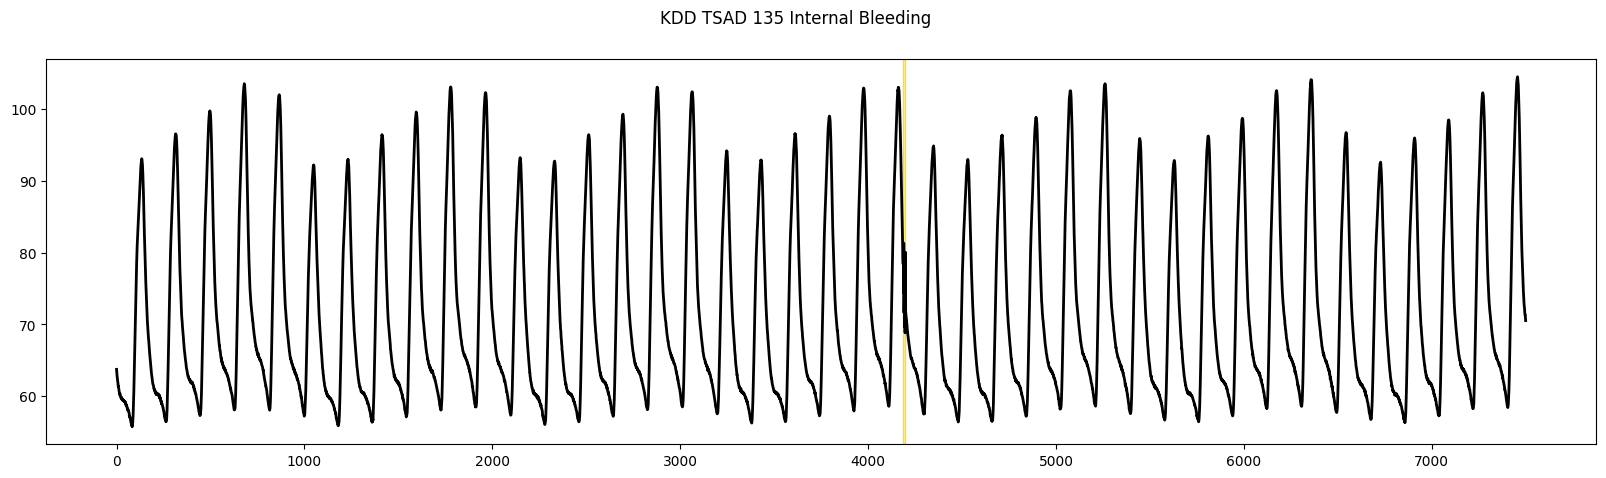

In [20]:
import pandas as pd
from aeon.datasets import load_kdd_tsad_135
from aeon.visualisation import plot_series_with_profiles


X, y = load_kdd_tsad_135()
plot_anomaly_detection(X, y, title="KDD TSAD 135 Internal Bleeding")

Another famous demo time series is the New York Taxi dataset. It is also univariate but contains multiple annotated anomalies and one can find additional unlabeled anomalous subsequences that relate to real-world anomalies. To demonstrate multivariate capabilities, we use a dataset with 133 sensor measurements from the Opportunity Mars rover.

`aeon` can automatically load all benchmark datasets from the TimeEval archive. You can find more details about this functionality in the API documentation of the [`load_anomaly_detection()`](https://www.aeon-toolkit.org/en/stable/api_reference/auto_generated/aeon.datasets.load_anomaly_detection.html)-function and the [TimeEval documentation](https://timeeval.readthedocs.io/en/latest/concepts/datasets.html#canonical-file-format).

In [21]:
from aeon.datasets import load_from_timeeval_csv_file

# Load the univariate New York taxi dataset and the multivariate Opportunity
# rover dataset:
X_nyc_taxi, y_nyc_taxi = load_from_timeeval_csv_file("./data/nyc_taxi.csv")
X_opp, y_opp = load_from_timeeval_csv_file("./data/S1-ADL1.csv")

print("Single channel NYC Taxi anomaly detection problem shape:", X_nyc_taxi.shape)
print("Multiple channel Opportunity anomaly detection problem test shape:", X_opp.shape)

Single channel NYC Taxi anomaly detection problem shape: (10320,)
Multiple channel Opportunity anomaly detection problem test shape: (51116, 133)


(<Figure size 2000x500 with 1 Axes>, array([<Axes: >], dtype=object))

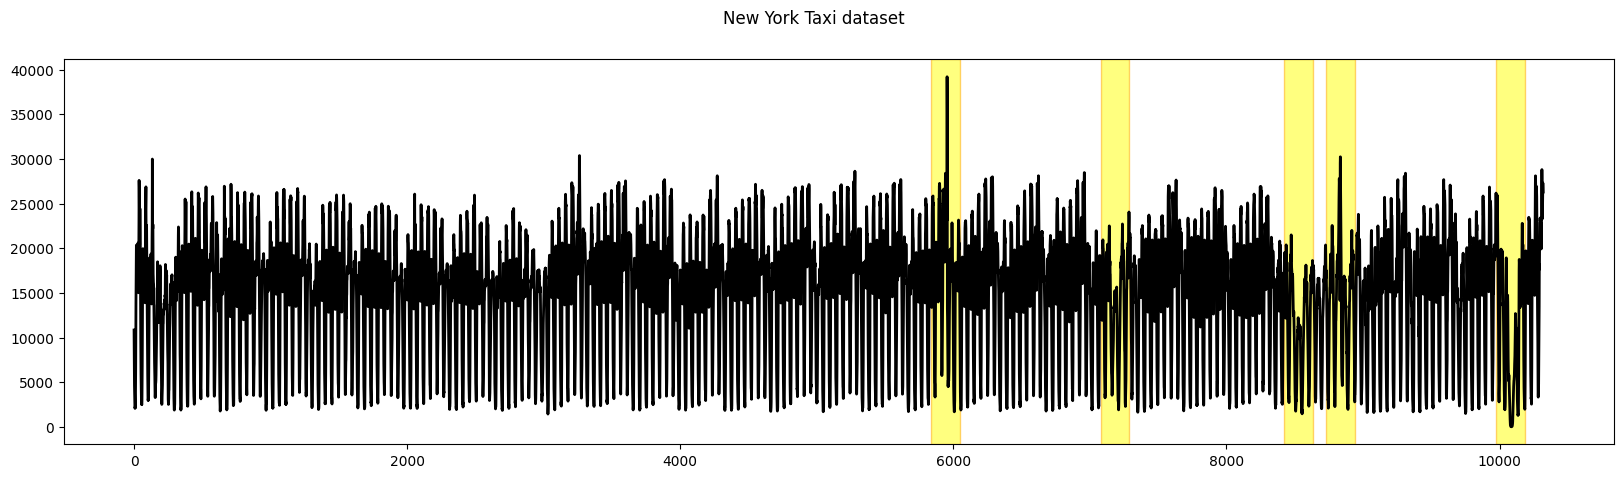

In [22]:
plot_anomaly_detection(X_nyc_taxi, y_nyc_taxi, title="New York Taxi dataset")

Too many (133) channels, just plotting 8!


(<Figure size 2000x500 with 1 Axes>, array([<Axes: >], dtype=object))

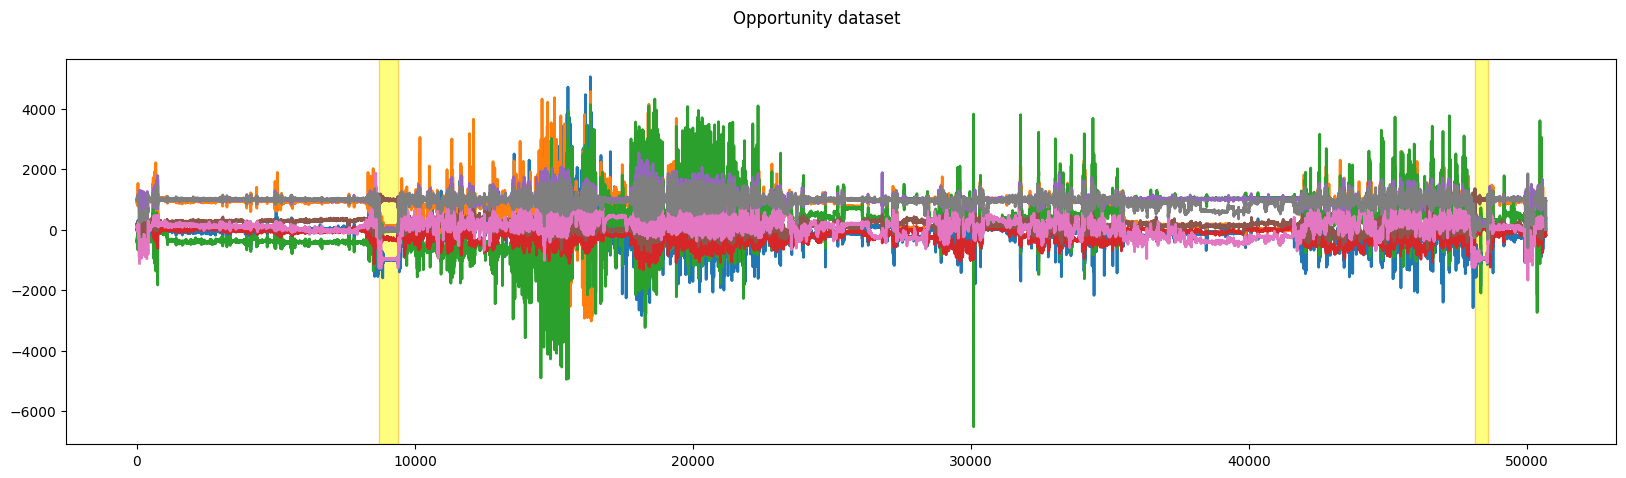

In [29]:
plot_anomaly_detection(X_opp, y_opp, title="Opportunity dataset")

## Distance-based anomaly detection

`aeon` follows the `scikit-learn` interface. Anomaly detectors can be trained
on a reference time series using `fit`, and then predictions for the target
time series can be made using `predict`.

Most anomaly detection problems, however, do not come with a (labeled)
training/reference time series. We, thus, focus our example on unsupervised
anomaly detection.

### STOMP

In [ ]:
from aeon.classification.convolution_based import RocketClassifier
from sklearn.metrics import accuracy_score

rc = RocketClassifier(rocket_transform="minirocket", random_state=42)
rc.fit(X_train_utsc, y_train_utsc)
pred1 = rc.predict(X_test_utsc)
accuracy_score(y_test_utsc, pred1)

### k-Means

In [ ]:
from aeon.regression.convolution_based import RocketRegressor
from sklearn.metrics import mean_squared_error

rr = RocketRegressor(rocket_transform="minirocket", random_state=42)
rr.fit(X_train_utser, y_train_utser)
pred2 = rr.predict(X_test_utser)
mean_squared_error(y_test_utser, pred2)

In [ ]:
from sklearn.metrics.cluster import adjusted_rand_score
from aeon.clustering import TimeSeriesKMeans
km = TimeSeriesKMeans(n_clusters=2)
km.fit(X_train_utsc)
pred3=km.predict(X_test_utsc)
adjusted_rand_score(y_test_utsc, pred3)

## Tree-based: Isolation Forest

- point-based
- window-based usage

show semi-supervised usage with KDD-TSAD 135

In [31]:
X_train, y_train = load_kdd_tsad_135(split="train")
np.testing.assert_array_equal(y_train, 0)

## Performance comparison of anomaly detectors

- metrics
- threshold-agnostic
- point-based vs. range-based
- thresholding

## Further information

There is a lot of information avaiable in the `aeon` documentation:

[`aeon` webpage](https://www.aeon-toolkit.org/en/stable/)

[Examples notebooks](https://www.aeon-toolkit.org/en/stable/examples.html)

You can get results published in clustering, classification and regression bake offs
 directly using `aeon`:

[Getting published results directly](https://www.aeon-toolkit.org/en/stable/examples/benchmarking/bakeoff_results.html)

More info on benchmarking:

[benchmarking](https://www.aeon-toolkit.org/en/stable/examples/benchmarking/benchmarking.html)

If you find anything wrong or unclear in the `aeon` documentation, please raise an issue on GitHub or mention it on Slack, we welcome new contributors.